# 首先构建模型

In [25]:
from keras.applications import Xception

conv_base = Xception(weights='imagenet',
                  include_top=False,
                  input_shape=(256, 256, 3))

In [26]:
conv_base.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            (None, 256, 256, 3)  0                                            
__________________________________________________________________________________________________
block1_conv1 (Conv2D)           (None, 127, 127, 32) 864         input_2[0][0]                    
__________________________________________________________________________________________________
block1_conv1_bn (BatchNormaliza (None, 127, 127, 32) 128         block1_conv1[0][0]               
__________________________________________________________________________________________________
block1_conv1_act (Activation)   (None, 127, 127, 32) 0           block1_conv1_bn[0][0]            
__________________________________________________________________________________________________
block1_con

In [27]:
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten

model = Sequential()
model.add(conv_base)
model.add(Flatten())
model.add(Dense(512, activation='relu'))
model.add(Dropout(0.1))
model.add(Dense(256, activation='relu'))
model.add(Dropout(0.1))
model.add(Dense(133, activation='softmax'))

In [28]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
xception (Model)             (None, 8, 8, 2048)        20861480  
_________________________________________________________________
flatten_2 (Flatten)          (None, 131072)            0         
_________________________________________________________________
dense_4 (Dense)              (None, 512)               67109376  
_________________________________________________________________
dropout_3 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_5 (Dense)              (None, 256)               131328    
_________________________________________________________________
dropout_4 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_6 (Dense)              (None, 133)               34181     
Total para

In [12]:
print('This is the number of trainable weights '
      'before freezing the conv base:', len(model.trainable_weights))

This is the number of trainable weights before freezing the conv base: 160


In [13]:
conv_base.trainable = False

In [14]:
print('This is the number of trainable weights '
      'after freezing the conv base:', len(model.trainable_weights))

This is the number of trainable weights after freezing the conv base: 6


In [15]:
from keras import optimizers
model.compile(loss='categorical_crossentropy',
              optimizer=optimizers.RMSprop(lr=2e-5),
              metrics=['acc'])

# 接下来进行数据增强

In [29]:
import os
import numpy as np
from keras.preprocessing.image import ImageDataGenerator

base_dir = './dogImages'

train_dir      = os.path.join(base_dir, 'train')
validation_dir = os.path.join(base_dir, 'valid')
test_dir       = os.path.join(base_dir, 'test')
pre_dir        = os.path.join(base_dir, 'pre')

In [10]:
from keras.preprocessing.image import ImageDataGenerator

train_datagen = ImageDataGenerator(
      rescale=1./255,
      rotation_range=40,
      width_shift_range=0.2,
      height_shift_range=0.2,
      shear_range=0.2,
      zoom_range=0.2,
      horizontal_flip=True,
      fill_mode='nearest')

# Note that the validation data should not be augmented!
validation_datagen = ImageDataGenerator(rescale=1./255)
test_datagen       = ImageDataGenerator(rescale=1./255)
# pre_datagen        = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
        train_dir,                # This is the target directory
        target_size=(256, 256),   # All images will be resized to 256x256
        batch_size=32,            # Since we use binary_crossentropy loss, we need binary labels
        class_mode='categorical')

validation_generator = validation_datagen.flow_from_directory(
        validation_dir,
        target_size=(256, 256),
        batch_size=32,
        class_mode='categorical')

test_generator = test_datagen.flow_from_directory(
        test_dir,
        target_size=(256, 256),
        batch_size=32,
        class_mode='categorical')

# pre_generator = pre_datagen.flow_from_directory(
#         pre_dir,
#         target_size = (256,256),
#         batch_size=32,
#         class_mode='categorical')

Found 6680 images belonging to 133 classes.
Found 835 images belonging to 133 classes.
Found 836 images belonging to 133 classes.
Found 2 images belonging to 2 classes.


# 进行模型训练

In [11]:
from keras.callbacks import ModelCheckpoint   

#为了解决一个bug，OSError
from PIL import ImageFile
ImageFile.LOAD_TRUNCATED_IMAGES = True

checkpointer = ModelCheckpoint(filepath='dogClassify.pretrained.augmentation.model.weights.best.hdf5', 
                               verbose=1, 
                               save_best_only=True)
history = model.fit_generator(
      train_generator,
      steps_per_epoch=128,
      epochs=30,
      validation_data=validation_generator,
      validation_steps=64, 
      callbacks=[checkpointer], 
      verbose=2)

Epoch 1/30
 - 73s - loss: 4.1831 - acc: 0.1753 - val_loss: 1.8191 - val_acc: 0.5950

Epoch 00001: val_loss improved from inf to 1.81909, saving model to dogClassify.pretrained.augmentation.model.weights.best.hdf5
Epoch 2/30
 - 67s - loss: 2.7122 - acc: 0.4466 - val_loss: 1.0255 - val_acc: 0.7291

Epoch 00002: val_loss improved from 1.81909 to 1.02555, saving model to dogClassify.pretrained.augmentation.model.weights.best.hdf5
Epoch 3/30
 - 65s - loss: 2.0272 - acc: 0.5564 - val_loss: 0.8274 - val_acc: 0.7710

Epoch 00003: val_loss improved from 1.02555 to 0.82741, saving model to dogClassify.pretrained.augmentation.model.weights.best.hdf5
Epoch 4/30
 - 65s - loss: 1.7679 - acc: 0.5941 - val_loss: 0.7702 - val_acc: 0.7894

Epoch 00004: val_loss improved from 0.82741 to 0.77016, saving model to dogClassify.pretrained.augmentation.model.weights.best.hdf5
Epoch 5/30
 - 67s - loss: 1.5654 - acc: 0.6286 - val_loss: 0.7046 - val_acc: 0.7884

Epoch 00005: val_loss improved from 0.77016 to 0.70

In [12]:
model.load_weights('dogClassify.pretrained.augmentation.model.weights.best.hdf5')

# 将模型训练过程进行可视化

In [13]:
import matplotlib.pyplot as plt 
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

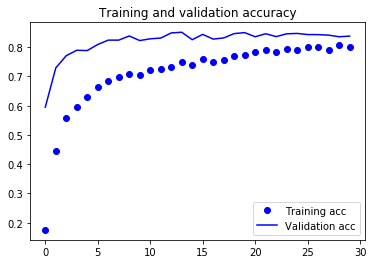

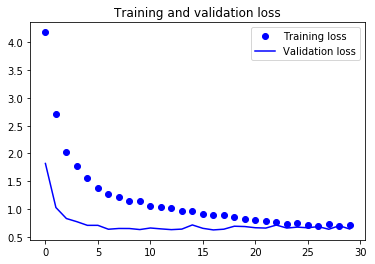

In [14]:
plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

# 进行模型微调

In [16]:
conv_base.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 256, 256, 3)  0                                            
__________________________________________________________________________________________________
block1_conv1 (Conv2D)           (None, 127, 127, 32) 864         input_1[0][0]                    
__________________________________________________________________________________________________
block1_conv1_bn (BatchNormaliza (None, 127, 127, 32) 128         block1_conv1[0][0]               
__________________________________________________________________________________________________
block1_conv1_act (Activation)   (None, 127, 127, 32) 0           block1_conv1_bn[0][0]            
__________________________________________________________________________________________________
block1_con

In [30]:
conv_base.trainable = True

set_trainable = False
for layer in conv_base.layers:
    if layer.name == 'block14_sepconv1':
        set_trainable = True
    if set_trainable:
        layer.trainable = True
    else:
        layer.trainable = False

In [31]:
model.compile(loss='categorical_crossentropy',
              optimizer=optimizers.RMSprop(lr=1e-5),
              metrics=['acc'])

In [18]:
from keras.callbacks import ModelCheckpoint   

checkpointer = ModelCheckpoint(filepath='dogClassify.pretrained.finetuning.augmentation.model.weights.best.hdf5', 
                               verbose=1, 
                               save_best_only=True)
history = model.fit_generator(
      train_generator,
      steps_per_epoch=100,
      epochs=30,
      validation_data=validation_generator,
      validation_steps=64, 
      callbacks=[checkpointer], 
      verbose=2)

Epoch 1/30
 - 62s - loss: 0.7732 - acc: 0.7778 - val_loss: 0.5693 - val_acc: 0.8266

Epoch 00001: val_loss improved from inf to 0.56932, saving model to dogClassify.pretrained.finetuning.augmentation.model.weights.best.hdf5
Epoch 2/30
 - 55s - loss: 0.7986 - acc: 0.7786 - val_loss: 0.5315 - val_acc: 0.8317

Epoch 00002: val_loss improved from 0.56932 to 0.53153, saving model to dogClassify.pretrained.finetuning.augmentation.model.weights.best.hdf5
Epoch 3/30
 - 55s - loss: 0.7162 - acc: 0.8084 - val_loss: 0.5406 - val_acc: 0.8226

Epoch 00003: val_loss did not improve from 0.53153
Epoch 4/30
 - 54s - loss: 0.7177 - acc: 0.8066 - val_loss: 0.5511 - val_acc: 0.8338

Epoch 00004: val_loss did not improve from 0.53153
Epoch 5/30
 - 56s - loss: 0.7210 - acc: 0.7938 - val_loss: 0.5409 - val_acc: 0.8221

Epoch 00005: val_loss did not improve from 0.53153
Epoch 6/30
 - 55s - loss: 0.6589 - acc: 0.8127 - val_loss: 0.5260 - val_acc: 0.8392

Epoch 00006: val_loss improved from 0.53153 to 0.52603,

In [32]:
model.load_weights('dogClassify.pretrained.finetuning.augmentation.model.weights.best.hdf5')

In [20]:
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(len(acc))

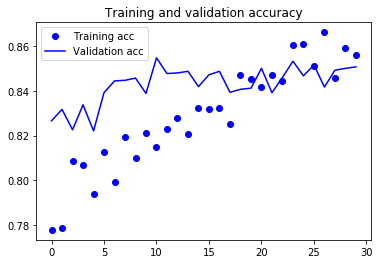

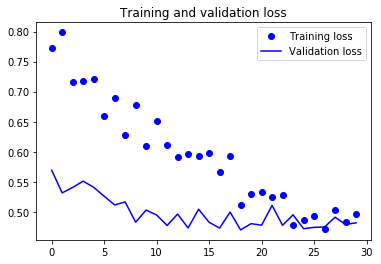

In [21]:
plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

# 对曲线进行平滑处理

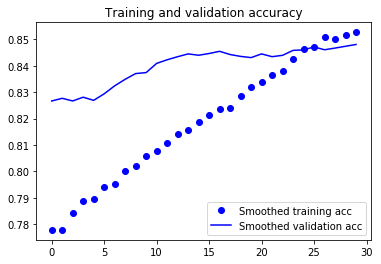

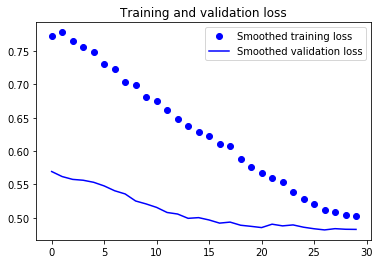

In [22]:
def smooth_curve(points, factor=0.8):
    smoothed_points = []
    for point in points:
        if smoothed_points:
            previous = smoothed_points[-1]
            smoothed_points.append(previous * factor + point * (1 - factor))
        else:
            smoothed_points.append(point)
    return smoothed_points

plt.plot(epochs,smooth_curve(acc), 'bo', label='Smoothed training acc')
plt.plot(epochs,smooth_curve(val_acc), 'b', label='Smoothed validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs,smooth_curve(loss), 'bo', label='Smoothed training loss')
plt.plot(epochs,smooth_curve(val_loss), 'b', label='Smoothed validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

# 模型评估

In [23]:
test_loss, test_acc = model.evaluate_generator(test_generator,steps=17, max_queue_size=50, workers=1, use_multiprocessing=True, verbose=0)
print("test_acc:",test_acc)

test_acc: 0.8584558823529411


# 将所要预测的图片显示出来

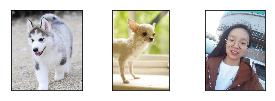

In [33]:
import os
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
imgDir = './dogImages/pre/'
imgFoldName = 'dog'
imgs = os.listdir(imgDir+imgFoldName)
imgNum = len(imgs)
imgFull = []
for i in range (imgNum):
    imgFull.append(imgDir+imgFoldName+"/"+imgs[i])
fig = plt.figure(figsize=(20,5))
for i in range(imgNum):
    ax = fig.add_subplot(3, 12, i + 1, xticks=[], yticks=[])
    ax.imshow(mpimg.imread(imgFull[i]))

# 使用自己的图片进行预测

In [36]:
from keras.preprocessing.image import ImageDataGenerator
pre_datagen = ImageDataGenerator(rescale=1./255)
pre_generator = pre_datagen.flow_from_directory(
        pre_dir,
        target_size = (256,256),
        batch_size=32,
        class_mode='categorical')
score = model.predict_generator(pre_generator,steps=1)
print('the predicted classes are ',np.argmax(score,axis=1)+1)

Found 3 images belonging to 2 classes.
the predicted classes are  [  5 124  48]
